<a href="https://colab.research.google.com/github/Jae-Yeong99/computer-vision/blob/main/Cats_Dog_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import time
import matplotlib.pyplot as plt
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm.auto import tqdm

In [ ]:
# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Download Dataset.
path = kagglehub.dataset_download("tongpython/cat-and-dog")

# Path for Training Set.
dog_train_path = os.path.join(path, "training_set/training_set/dogs/")
cat_train_path = os.path.join(path, "training_set/training_set/cats/")

# Path for Test Set.
dog_test_path = os.path.join(path, "test_set/test_set/dogs/")
cat_test_path = os.path.join(path, "test_set/test_set/cats/")


# Making Labels for the dataset.
def load_data(dog_path, cat_path):
    dog_files = [os.path.join(dog_path, file) for file in os.listdir(dog_path) if file.endswith('.jpg')]
    cat_files = [os.path.join(cat_path, file) for file in os.listdir(cat_path) if file.endswith('.jpg')]
    image_paths = dog_files + cat_files
    labels = [1] * len(dog_files) + [0] * len(cat_files)  # 1: dog, 0: cat
    return image_paths, labels

# Path and label for the dataset
train_image_paths, train_labels = load_data(dog_train_path, cat_train_path)
test_image_paths, test_labels = load_data(dog_test_path, cat_test_path)

In [ ]:
class CatDogDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image and convert
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Transform for the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image
    transforms.ToTensor(),         # Into Tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image
])

In [ ]:
# Load dataset
train_dataset = CatDogDataset(train_image_paths, train_labels, transform=transform)
test_dataset = CatDogDataset(test_image_paths, test_labels, transform=transform)

In [ ]:

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
class CatDogClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Reduces spatial size (e.g., 64x64 -> 32x32)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        flattened_features = 2 * 128 * (128 // 2 // 2 // 2 // 2) * (128 // 2 // 2 // 2 // 2)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(in_features=flattened_features, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.classifier(x)
        return x

In [ ]:
# Model to device
model = CatDogClassifier().to(device)
# Loss Function
criterion = nn.CrossEntropyLoss()
# Optimized
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Define training
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in tqdm(range(epochs), desc='Training'):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")
    torch.save(model.state_dict(), 'model.pth')

In [ ]:
train_model(model, train_loader, criterion, optimizer, epochs= 20)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 0.8128
Epoch 2/20, Loss: 0.5971
Epoch 3/20, Loss: 0.5494
Epoch 4/20, Loss: 0.5119
Epoch 5/20, Loss: 0.4857
Epoch 6/20, Loss: 0.4471
Epoch 7/20, Loss: 0.4130
Epoch 8/20, Loss: 0.3835
Epoch 9/20, Loss: 0.3550
Epoch 10/20, Loss: 0.3453
Epoch 11/20, Loss: 0.3074
Epoch 12/20, Loss: 0.2911
Epoch 13/20, Loss: 0.2754
Epoch 14/20, Loss: 0.2528
Epoch 15/20, Loss: 0.2426
Epoch 16/20, Loss: 0.2308
Epoch 17/20, Loss: 0.1947
Epoch 18/20, Loss: 0.1860
Epoch 19/20, Loss: 0.1779
Epoch 20/20, Loss: 0.1573


In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    class_names = ['Cat', 'Dog']
    plotted_first_batch = False

    def unnormalize(tensor):
        tensor = tensor * 0.5 + 0.5
        tensor = torch.clamp(tensor, 0, 1)
        return tensor

    with torch.no_grad():
        start_time = time.time()
        for images, labels in test_loader:
            if images.numel() == 0:
                 continue

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            if not plotted_first_batch:
                try:
                    num_images_to_display = min(10, images.size(0))
                    images_to_display = images[:num_images_to_display]
                    predicted_to_display = predicted[:num_images_to_display]

                    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
                    axes = axes.ravel()

                    for i in range(num_images_to_display):
                        img = images_to_display[i].cpu()
                        img = unnormalize(img)
                        img = img.permute(1, 2, 0)

                        predicted_label_text = class_names[predicted_to_display[i].item()]

                        axes[i].imshow(img)
                        axes[i].set_title(f"Prediction: {predicted_label_text}")
                        axes[i].axis('off')

                    plt.tight_layout()
                    plt.show()
                    plotted_first_batch = True
                except Exception as e:
                    print(f"An error occurred during sample image plotting: {e}")


            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        end_time = time.time()

    print(f"Total Time: {end_time-start_time:.2f}seconds")
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

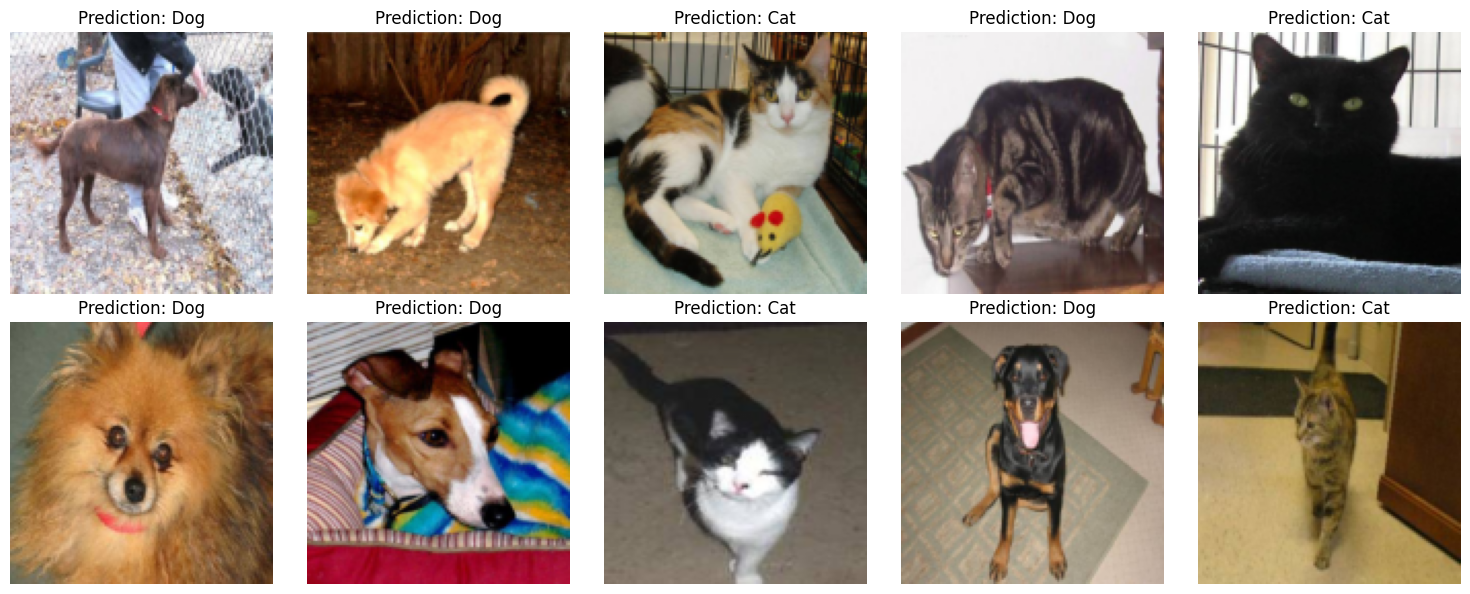

Total Time: 7.86seconds
Test Accuracy: 89.37%


In [ ]:
pre_train = torch.load('model.pth')
model.load_state_dict(pre_train)
test_model(model, test_loader)